In [4]:
"""
This uses a GA to do the following:
1) Manage GC ratio(between 50% and 65% as done in BNT)
2) Codon optimization

"""
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
import json
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from simple_compare import SequenceComp
from codon_mapping import codon_optimize
import os

# print(os.listdir(""))
PATH_codon_to_protein = "codon_to_protein.json"
Spike_PATH = "ncov-s.fasta"
Vac_PATH = "vaccine-s.fasta"
PATH_codon_map = "vaccine_dict.json"


codonProtein = json.loads(open(PATH_codon_to_protein, "r").read())
revCodonProtein = {}
for i, j in codonProtein.items():
    if j in revCodonProtein:
        revCodonProtein[j].append(i)
    else:
        revCodonProtein[j] = [i]
print(revCodonProtein)


{'A': ['GCA', 'GCC', 'GCG', 'GCT'], 'C': ['TGC', 'TGT'], 'D': ['GAC', 'GAT'], 'E': ['GAA', 'GAG'], 'F': ['TTC', 'TTT'], 'G': ['GGA', 'GGC', 'GGG', 'GGT'], 'H': ['CAC', 'CAT'], 'I': ['ATA', 'ATC', 'ATT'], 'K': ['AAA', 'AAG'], 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 'M': ['ATG'], 'N': ['AAC', 'AAT'], 'P': ['CCA', 'CCC', 'CCG', 'CCT'], 'Q': ['CAA', 'CAG'], 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'], 's': ['TAA', 'TAG', 'TGA'], 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'], 'T': ['ACA', 'ACC', 'ACG', 'ACT'], 'V': ['GTA', 'GTC', 'GTG', 'GTT'], 'W': ['TGG'], 'Y': ['TAC', 'TAT']}


In [12]:
class OptimizeSeq:
    def __init__(self, seq):
        self.seq = seq
    def graph_gc(self, seq=None, frame=10):
        if not seq:
            seq = self.seq
        x, y = [], []
        for i in range(0, len(seq), frame):
            x.append(i)
            y.append(self.gc_content(seq, window=[i, i+frame]))
        plt.plot(x, y)
        # plt.show()
    def gc_content(self, seq=None, window=None):
        if not seq:
            seq = self.seq
        if not window:
            window = [0, len(seq)]
        # Evaluate the level of GC content within the S spike
        num_GC = len(list(filter(lambda x: x == "G" or x == "C", seq[window[0]:window[1]])))
        return num_GC / (window[1] - window[0])
    def norm_gc_cont(self, seq=None, window=None):
        if not seq:
            seq = self.seq
        if not window:
            window = [.60, .95]
        # Perform inverse normal to set -3-3 SD of GC content within window
        # scipy.stats.norm.cdf(x, mean, sd)
        # norm.ppf(area, mean, sd)
        # mean = mean(window), sd = (window[0]-mean)/+-3
        mean = (window[0] + window[1])/2
        sd = (window[1] - mean)/1
        # Find pdf of the particular GC content
        return norm.pdf(self.gc_content(seq), loc=mean, scale=sd)
    def calc_temp(self):
        # Calculate melting temperature for sequence
        return mt.Tm_NN(self.seq)
    def prot_similar(self, comp):
        # Compare comp with self.seq
        dissim_prot = 0
        for i in range(0, len(comp), 3):
            if not codonProtein["".join(comp[i:i+3])] == codonProtein["".join(self.seq[i:i+3])]:
                dissim_prot += 1
        return dissim_prot
    def fitness(self, comp, alpha=0.5):
        # Calculate (1-alpha)*Prot_similar + (alpha)*GC_content
        # comp = comparison sequence to find proteins similar
        return (self.norm_gc_cont(comp))
    def evaluate(self):
        # Given the type of loss(codon differences, protein diff, or nucleotide diff, evaluate the best solution by simple brute force)
        loss = 0
        best_found = list(self.seq)
        self.seq = best_found
        this_found = best_found
        best_loss = self.fitness(best_found)
        for i in range(0, len(best_found), 3):
            print(i, len(best_found))
            # Find all possible amino acid combinations
            current_prot = codonProtein["".join(best_found[i:i+3])]
            possible_prot = revCodonProtein[current_prot]
            for ii in possible_prot:
                this_found[i:i+3] = ii
                this_loss = self.fitness(this_found)
                if this_loss > best_loss:
                    print("".join(best_found[i:i+50]), best_loss)
                    best_loss = float(this_loss)
                    best_found = list(this_found)
            this_loss = float(best_loss)
            this_found = list(best_found)
        print(self.gc_content(best_found))
        return best_found, best_loss


 L  P
TTCAAGATCTACAGCAAGCACACGCCCATCAACCTCGTGCGCGACCTCCC
                       !  !              !  !  !  
TTCAAGATCTACAGCAAGCACACCCCTATCAACCTCGTGCGGGATCTGCC
 F  K  I  Y  S  K  H  T  P  I  N  L  V  R  D  L  P
                                                  


  Q  G  F  S  A  L  E  P  L  V  D  L  P  I  G  I  
CCAGGGCTTCTCGGCCCTCGAGCCCCTCGTCGACCTCCCCATCGGCATCA
!           !  !  !  !     !  !  !  !             
TCAGGGCTTCTCTGCTCTGGAACCCCTGGTGGATCTGCCCATCGGCATCA
  Q  G  F  S  A  L  E  P  L  V  D  L  P  I  G  I  
                                                  


N  I  T  R  F  Q  T  L  L  A  L  H  R  S  Y  L  T 
ACATCACCCGCTTCCAGACCCTCCTCGCCCTCCACCGCAGCTACCTCACC
          !  !     !  !  !     !   ! !        !  !
ACATCACCCGGTTTCAGACACTGCTGGCCCTGCACAGAAGCTACCTGACA
N  I  T  R  F  Q  T  L  L  A  L  H  R  S  Y  L  T 
                                                  


 P  G  D  S  S  S  G  W  T  A  G  A  A  A  Y  Y  V
CCCGGCGACAGCAGCAGCGGCTGGACCGCCGGCGCCGCCGCCTACTACGT
  !     !          

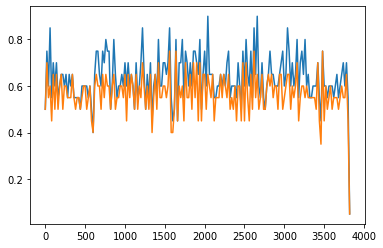

In [13]:

# Input: Genetic sequence to the spike
init_spike = str(SeqIO.read(Spike_PATH, "fasta").seq)
# For evaluation: Genetic sequence to the vaccine path
vac_encode = str(SeqIO.read(Vac_PATH, "fasta").seq)

# Version 0: Comparing the vaccine to the virus
l = SequenceComp(init_spike, vac_encode)
l.print_compare(codonProtein)

# Version 1: Comparing the vaccine to the codon map
optimized_spike = codon_optimize(init_spike, PATH_codon_map)
l.change_seq("seq_1", optimized_spike)
l.print_compare(codonProtein)

# Version 2: Discrete optimization
k = OptimizeSeq(str(SeqIO.read(Spike_PATH, "fasta").seq))

arr, loss = k.evaluate()
k.seq = arr
# Comp new arr with the vac
l.change_seq("seq_1", "".join(arr))
l.change_seq("seq_2", "".join(vac_encode))

l.print_compare(codonProtein)
print(k.gc_content(arr), k.gc_content(vac_encode))

k.graph_gc(k.seq, 20)
k.graph_gc(vac_encode, 20)
plt.show()

0.6378859236002093
0.5698587127158555
0.37310308738880166


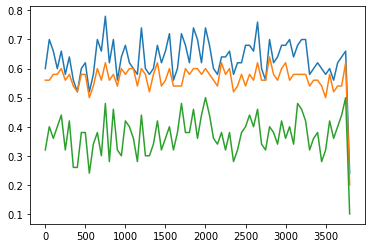

In [14]:
k.graph_gc(k.seq, 50)
print(k.gc_content(k.seq))
k.graph_gc(vac_encode, 50)
print(k.gc_content(vac_encode))
k.graph_gc(init_spike, 50)
print(k.gc_content(init_spike))
plt.show()